# Analysis of Employee Exit Surveys

In this analysis, we'll use exit surveys from employees of the Department of Education, Training and Employment (DETE) and the Technical and Further Education (TAFE) institute in Queensland, Australia to answer the following questions:

1. Are employees who only worked for the institutes for a short period of time resigning due to some kind of dissatisfaction? What about employees who have been there longer?

2. Are younger employees resigning due to some kind of dissatisfaction? What about older employees?

## Importing data, dropping irrelevant columns

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
dete_survey = pd.read_csv('dete_survey.csv', na_values='Not Stated')
tafe_survey = pd.read_csv('tafe_survey.csv')

dete_survey has 52 columns and 822 entries. The columns we need don't seem to be missing many values.

tafe_survey has 72 columns and 702 entries.

We'll start by dropping the columns that are irrelevant for the analysis.


In [49]:
dete_survey_updated = dete_survey.drop(dete_survey.columns[28:49], axis=1)

In [50]:
tafe_survey_updated = tafe_survey.drop(tafe_survey.columns[17:66], axis=1)

## Standardizing columns

Next, we standardize the relevant column names in each dataset so we can merge them for the analysis.

In [51]:
dete_survey_updated.columns = dete_survey_updated.columns.str.lower().str.strip().str.replace(' ', '_')

In [52]:
column_names_map = {'Record ID': 'id', 'CESSATION YEAR': 'cease_date', 'Reason for ceasing employment': 'separationtype', 'Gender. What is your Gender?': 'gender', 'CurrentAge. Current Age': 'age', 'Employment Type. Employment Type': 'employment_status', 'Classification. Classification': 'position', 'LengthofServiceOverall. Overall Length of Service at Institute (in years)': 'institute_service', 'LengthofServiceCurrent. Length of Service at current workplace (in years)': 'role_service'}
tafe_survey_updated.rename(columns=column_names_map, inplace=True)

## Focusing in on employees who resigned

Now, we select only the entries of both datasets where the reason for ceasing employment ('separationtype') is resignation.

In [53]:
dete_resignations = dete_survey_updated[dete_survey_updated['separationtype'].str.contains("Resignation", regex=False)].copy()
tafe_resignations = tafe_survey_updated[tafe_survey_updated['separationtype']=='Resignation'].copy()

Before proceeding any further, we'll do a sanity check to validate that the 
dates of employment termination in both datasets ('cease_date') are reasonable.

In [54]:
# Standardizing data format in the 'cease_date' column
dete_resignations['cease_date'] = dete_resignations['cease_date'].str.extract(r"/?([0-9]{4})")
dete_resignations['cease_date'] = dete_resignations['cease_date'].astype('float')

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)



In [55]:
# Checking if any entries have a start date that is after their cease date
dete_resignations[dete_resignations['dete_start_date'] > dete_resignations['cease_date']]

,id,separationtype,cease_date,dete_start_date,role_start_date,position,classification,region,business_unit,employment_status,...,work_life_balance,workload,none_of_the_above,gender,age,aboriginal,torres_strait,south_sea,disability,nesb


In [56]:
tafe_resignations['cease_date'].value_counts().sort_index()

2009.0      2
2010.0     68
2011.0    116
2012.0     94
2013.0     55
Name: cease_date, dtype: int64

In [57]:
dete_resignations['cease_date'].value_counts().sort_index()

2006.0      1
2010.0      2
2012.0    129
2013.0    146
2014.0     22
Name: cease_date, dtype: int64

Having validated that the data looks reasonable, we'll create a new column in the dete_resignations dataset to reflect the years of service ('institute_service'). This will allow us to distinguish between employees who only worked for the institutes for a short period of time vs those who have been at the job longer.

In [58]:
dete_resignations['institute_service'] = dete_resignations['cease_date'] - dete_resignations['dete_start_date']

## Categorizing employees by whether they resigned due to dissatisfaction

Now we'll identify the employees who resigned due to dissatisfaction by adding a 'dissatisfied' column based on the data contained in the contributing factors columns

In [59]:
# Standardize the data by converting values to either True, False, or NaN
def update_vals(x):
    if x == '-':
        return False
    elif pd.isnull(x):
        return np.nan
    else:
        return True

In [60]:
tafe_resignations['dissatisfied'] = tafe_resignations[['Contributing Factors. Dissatisfaction', 'Contributing Factors. Job Dissatisfaction']].applymap(update_vals).any(axis=1, skipna=False)
tafe_resignations_up = tafe_resignations.copy()

In [61]:
# Check the unique values after the updates
tafe_resignations_up['dissatisfied'].value_counts(dropna=False)

False    241
True      91
NaN        8
Name: dissatisfied, dtype: int64

In [62]:
# Update the values in columns related to dissatisfaction to be either True, False, or NaN
dete_resignations['dissatisfied'] = dete_resignations[['job_dissatisfaction',
       'dissatisfaction_with_the_department', 'physical_work_environment',
       'lack_of_recognition', 'lack_of_job_security', 'work_location',
       'employment_conditions', 'work_life_balance',
       'workload']].any(1, skipna=False)
dete_resignations_up = dete_resignations.copy()
dete_resignations_up['dissatisfied'].value_counts(dropna=False)

False    162
True     149
Name: dissatisfied, dtype: int64

## Combining datasets

In [63]:
dete_resignations_up['institute'] = 'DETE'
tafe_resignations_up['institute'] = 'TAFE'

In [64]:
combined = pd.concat([dete_resignations_up, tafe_resignations_up], ignore_index=True)
combined.notnull().sum().sort_values()

torres_strait                                            0
south_sea                                                3
aboriginal                                               7
disability                                               8
nesb                                                     9
business_unit                                           32
classification                                         161
region                                                 265
role_start_date                                        271
dete_start_date                                        283
role_service                                           290
career_move_to_public_sector                           311
employment_conditions                                  311
work_location                                          311
lack_of_job_security                                   311
job_dissatisfaction                                    311
dissatisfaction_with_the_department                    3

In [65]:
# Dopping columns with over 500 null values
combined_updated = combined.dropna(thresh=500, axis=1)

## Standardizing institute_service column

In [66]:
combined_updated['institute_service'].value_counts(dropna=False)

NaN                   88
Less than 1 year      73
1-2                   64
3-4                   63
5-6                   33
11-20                 26
5.0                   23
1.0                   22
7-10                  21
0.0                   20
3.0                   20
6.0                   17
4.0                   16
2.0                   14
9.0                   14
7.0                   13
More than 20 years    10
8.0                    8
13.0                   8
15.0                   7
20.0                   7
12.0                   6
14.0                   6
10.0                   6
22.0                   6
17.0                   6
18.0                   5
16.0                   5
11.0                   4
23.0                   4
24.0                   4
19.0                   3
21.0                   3
39.0                   3
32.0                   3
25.0                   2
26.0                   2
28.0                   2
30.0                   2
36.0                   2


In [67]:
combined_updated['institute_service_up'] = combined_updated['institute_service'].astype('str').str.extract(r"(\d+)")
combined_updated['institute_service_up'] = combined_updated['institute_service_up'].astype('float')

# Check the years extracted are correct
combined_updated['institute_service_up'].value_counts()

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: FutureWarning:

currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



1.0     159
3.0      83
5.0      56
7.0      34
11.0     30
0.0      20
20.0     17
6.0      17
4.0      16
9.0      14
2.0      14
13.0      8
8.0       8
15.0      7
17.0      6
10.0      6
12.0      6
14.0      6
22.0      6
16.0      5
18.0      5
24.0      4
23.0      4
39.0      3
19.0      3
21.0      3
32.0      3
28.0      2
36.0      2
25.0      2
30.0      2
26.0      2
29.0      1
38.0      1
42.0      1
27.0      1
41.0      1
35.0      1
49.0      1
34.0      1
33.0      1
31.0      1
Name: institute_service_up, dtype: int64

## Categorizing based on years of experience

In [68]:
def years_to_stages(val):
    if pd.isnull(val):
        return np.nan
    elif val < 3:
        return "New"
    elif val >= 3 and val < 7:
        return "Experienced"
    elif val >= 7 and val < 11:
        return "Established"
    elif val >= 11:
        return "Veteran"
    else:
        return "Other"

In [69]:
combined_updated['service_cat'] = combined_updated['institute_service_up'].apply(years_to_stages)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [70]:
combined_updated['service_cat'].value_counts()

New            193
Experienced    172
Veteran        136
Established     62
Name: service_cat, dtype: int64

## Conducting the analysis

In [71]:
combined_updated['dissatisfied'].value_counts(dropna=False)

False    403
True     240
NaN        8
Name: dissatisfied, dtype: int64

In [72]:
combined_updated['dissatisfied'] = combined_updated['dissatisfied'].fillna(False)

/dataquest/system/env/python3/lib/python3.4/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [76]:
ptable = combined_updated.pivot_table(index='service_cat', values='dissatisfied')

In [80]:
ptable = ptable.reindex(['New', 'Experienced', 'Established', 'Veteran'])

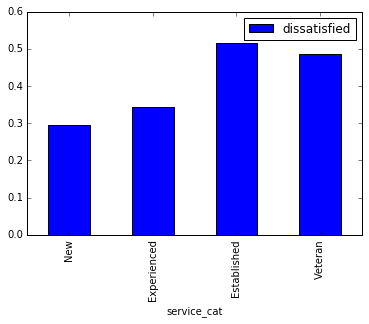

In [81]:
ptable.plot(kind='bar')

It looks like the longer someone is employed, the greater the chance of their resignation being due to dissatisfaction.